In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

%matplotlib inline

/Users/hasannagib/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/hasannagib/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


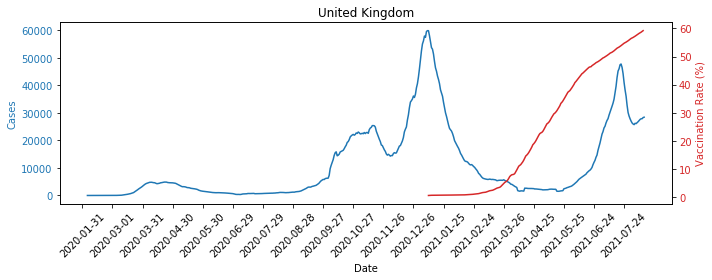

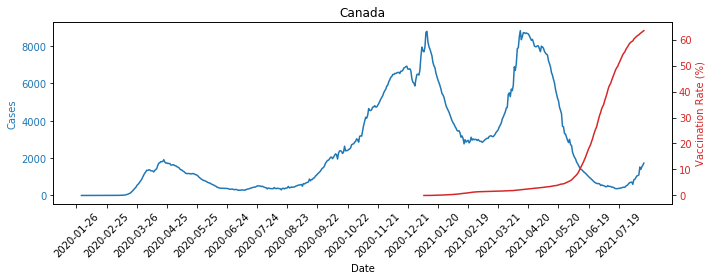

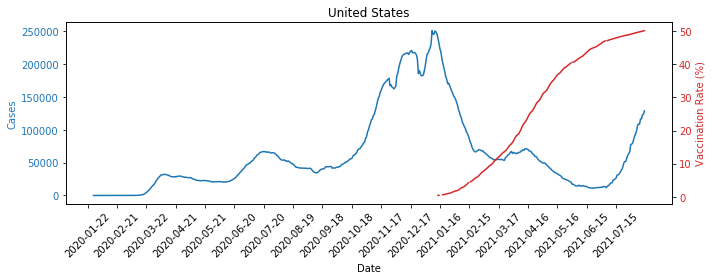

In [168]:
df_country = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

country = {
    'GBR':'United Kingdom',
    'CAN':'Canada',
    'USA':'United States'
}

for k,v in country.items():
    df_plot = df_country.query(f'iso_code == "{k}"').set_index('date')

    # Create some mock data
    t = range(df_plot.shape[0])
    data1 = df_plot['new_cases_smoothed']#.rolling(7).mean()
    data2 = df_plot['people_fully_vaccinated_per_hundred']#.rolling(7).mean()


    fig, ax1 = plt.subplots(figsize=(10,4))

    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cases', color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax1.set_xticks(t[::30])
    ax1.set_xticklabels(df_plot.index[::30])
    plt.xticks(rotation=45)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Vaccination Rate (%)', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(country[k])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    

In [20]:
df_state_name = pd.read_csv('../data/us_state_names.csv').set_index('state')
df_state_name.head()

,state_name
state,
AL,Alabama
AK,Alaska
AZ,Arizona
AR,Arkansas
CA,California


In [21]:
df_pop = pd.read_csv('../data/state_population.csv')
df_pop = df_pop.set_index('state').dropna()

df_pop.head()

,pop_per_sqr_mile,population
state,,
AL,95,"4,858,979"
AK,1,"738,432"
AZ,60,"6,828,065"
AR,57,"2,978,204"
CA,251,"39,144,818"


In [22]:
df_pop = df_state_name.join(df_pop).dropna()
df_pop['population'] = df_pop['population'].apply(lambda x: int(x.replace(',', '')))

df_politics = pd.read_csv('../data/1976-2020-president.csv').query('year == 2020')
df_politics['pct_vote'] = df_politics['candidatevotes']/df_politics['totalvotes']
df_dem = df_politics.query('party_detailed == "DEMOCRAT"')[['state_po', 'pct_vote']]#.set_index('state_po')
df_rep = df_politics.query('party_detailed == "REPUBLICAN"')[['state_po', 'pct_vote']]#.set_index('state_po')
df_pol = df_dem.merge(df_rep, on='state_po', suffixes=['_dem', '_rep']).set_index('state_po')
df_pol.head()

,pct_vote_dem,pct_vote_rep
state_po,,
AL,0.365700,0.620316
AK,0.427720,0.528331
AZ,0.493647,0.490560
AR,0.347751,0.623957
CA,0.634839,0.343207


In [23]:
df = df_pop.join(df_pol)
df['party'] = (df['pct_vote_dem'] > df['pct_vote_rep']).apply(lambda x: 'DEM' if x == True else 'REP')
df.head()

,state_name,pop_per_sqr_mile,population,pct_vote_dem,pct_vote_rep,party
state,,,,,,
AL,Alabama,95,4858979,0.365700,0.620316,REP
AK,Alaska,1,738432,0.427720,0.528331,REP
AZ,Arizona,60,6828065,0.493647,0.490560,DEM
AR,Arkansas,57,2978204,0.347751,0.623957,REP
CA,California,251,39144818,0.634839,0.343207,DEM


In [162]:
# load historical
df_vax_ts = pd.read_csv('../data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv', parse_dates=['Date'])
df_vax_ts.columns = [x.lower() for x in df_vax_ts.columns]

# # add new data
# df_vax_ts_ = pd.read_json('https://data.cdc.gov/resource/unsk-b7fc.json')
# df_vax_ts_.columns = df_vax_ts.columns
# df_vax_ts['date'] = pd.to_datetime(df_vax_ts['date'])

# # de-dupe
# df_vax_ts = pd.concat([df_vax_ts, df_vax_ts_]).groupby(['location', 'date']).mean().reset_index()

df_vax_ts = df_vax_ts[['date','location', 'series_complete_yes']].rename(columns={'location':'state'})
df_vax_ts['date'] = pd.to_datetime(df_vax_ts['date']) 
df_vax_ts = df_vax_ts.set_index(['state', 'date'])
df_vax_ts.head()

,,series_complete_yes
state,date,
DC,2021-08-13,395147
IL,2021-08-13,6269965
MH,2021-08-13,17808
VT,2021-08-13,417479
IA,2021-08-13,1588148


In [163]:
df_death = pd.read_csv('../data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')

# df_death_ = pd.read_json('https://data.cdc.gov/resource/9mfq-cb36.json')
# df_death = pd.concat([df_death, df_death_]).groupby(['state', 'submission_date']).mean().reset_index()

df_death['state'] = df_death['state'].apply(lambda x: 'NY' if x=='NYC' else x)
df_death = df_death.groupby(['state', 'submission_date']).sum().reset_index()

df_death['submission_date'] = pd.to_datetime(df_death['submission_date'])
df_death = df_death.set_index('submission_date')

df_death_ts = df_death.reset_index().rename(columns={'submission_date':'date'})
df_death_ts['date'] = pd.to_datetime(df_death_ts['date']) 

df_death_ts = df_death_ts.reset_index().set_index('state')

df_death_ts = df_death_ts.reset_index().groupby(['state', 'date']).mean()
df_death_ts.head()

index  tot_cases  conf_cases  prob_cases  new_case  \
state date                                                             
AK    2020-01-22     21          0         0.0         0.0         0   
      2020-01-23     23          0         0.0         0.0         0   
      2020-01-24     25          0         0.0         0.0         0   
      2020-01-25     27          0         0.0         0.0         0   
      2020-01-26     29          0         0.0         0.0         0   

                  pnew_case  tot_death  conf_death  prob_death  new_death  \
state date                                                                  
AK    2020-01-22        0.0          0         0.0         0.0          0   
      2020-01-23        0.0          0         0.0         0.0          0   
      2020-01-24        0.0          0         0.0         0.0          0   
      2020-01-25        0.0          0         0.0         0.0          0   
      2020-01-26        0.0          0         0.0         0.0          0   

                  pnew_death  
state date                    
AK    2020-01-22         0.0  
      2020-01-23         0.0  
      2020-01-24         0.0  
      2020-01-25         0.0  
      2020-01-26         0.0

In [164]:
df_ts = df_vax_ts.join(df_death_ts).join(df[['population', 'pop_per_sqr_mile', 'party', 'state_name']])
df_ts['death_per_100K'] = 100_000*df_ts['tot_death']/df_ts['population']
df_ts['vax_rate'] = 100*df_ts['series_complete_yes']/df_ts['population'].fillna(0)


In [165]:
df_ts = df_ts.sort_index()
df_30d = df_ts.groupby(['state'])[['tot_death']].diff().rename(columns={'tot_death':'new_death'}).groupby('state').rolling(30).sum()[['new_death']].rename(columns={'new_death':'new_death_30d'}).fillna(0)
df_30d.index.names = ['', 'state', 'date']
df_ts_1 = df_ts.join(df_30d)
df_ts_1['new_death_30d_per_100K'] = 100_000*df_ts_1['new_death_30d']/df_ts_1['population']

df_ts_1 = df_ts_1[['vax_rate', 'death_per_100K', 'new_death_30d_per_100K', 'party', 'pop_per_sqr_mile', 'state_name']].drop_duplicates()
df_ts_1.head()

vax_rate  death_per_100K  new_death_30d_per_100K party  \
state date                                                                    
AK    2020-12-14 AK       0.0       35.074320                     0.0   REP   
      2020-12-15 AK       0.0       35.480586                     0.0   REP   
      2020-12-16 AK       0.0       35.616008                     0.0   REP   
      2020-12-17 AK       0.0       35.886852                     0.0   REP   
      2020-12-18 AK       0.0       36.022274                     0.0   REP   

                     pop_per_sqr_mile state_name  
state date                                        
AK    2020-12-14 AK               1.0     Alaska  
      2020-12-15 AK               1.0     Alaska  
      2020-12-16 AK               1.0     Alaska  
      2020-12-17 AK               1.0     Alaska  
      2020-12-18 AK               1.0     Alaska

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
/Users/hasannagib/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/hasannagib/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/hasannagib/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/hasannagi

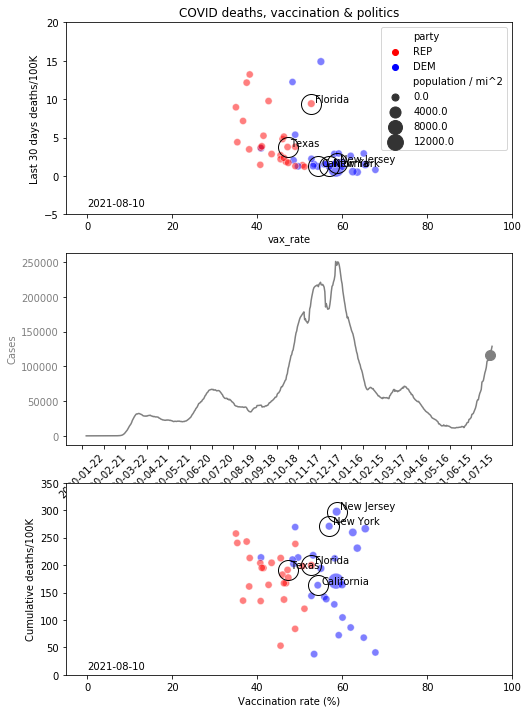

In [225]:
dts = pd.date_range('2021-08-10', '2021-08-12')
states = ['FL', 'TX', 'CA', 'NJ', 'NY']

fig, (ax1, ax3, ax2) = plt.subplots(3, 1, figsize=(8,12))

def animate(i):
    ax1.cla()
    ax1.set_xlim(-5,100)
    ax1.set_ylim(-5,20)
    dt = dts[i]
    df_plot_ts = df_ts_1.xs(dt, level=1, drop_level=False).reset_index().dropna().set_index('state').drop_duplicates()

    x='vax_rate'
    y='new_death_30d_per_100K'
    #y='death_per_100K' 
    palette={'DEM':'blue', 'REP':'red'}
    
    p = sns.scatterplot(
        x=x, y=y,
        data=df_plot_ts.rename(columns={'pop_per_sqr_mile':'population / mi^2'}), 
        hue='party',
        size='population / mi^2',
        sizes=(50,250),
        palette=palette,
        alpha=0.5,
        ax=ax1,
        #legend=False
    )
    
    circle_rad = 10
    ax1.text(0,-4, dt.strftime('%Y-%m-%d'))
    for st in states:
        ax1.text(
            df_plot_ts.loc[st][x]*1.015, 
            df_plot_ts.loc[st][y]*1.015, 
            df_plot_ts.loc[st]['state_name']
        )
        
        ax1.plot(
            df_plot_ts.loc[st][x], 
            df_plot_ts.loc[st][y], 
            'o', ms=circle_rad*2, 
            mec='k', 
            mfc='none', 
            mew=1
        )
        
    ax1.set_ylabel(f'Last 30 days deaths/100K')
    #ax1.set_xlabel('Vaccination rate (%)')
    ax1.set_title('COVID deaths, vaccination & politics')
    
    
    ax2.cla()
    ax2.set_xlim(-5,100)
    ax2.set_ylim(0,350)
    dt = dts[i]
    df_plot_ts = df_ts_1.xs(dt, level=1, drop_level=False).reset_index().dropna().set_index('state')

    x='vax_rate'
    y='death_per_100K' 
    palette={'DEM':'blue', 'REP':'red'}
    
    p = sns.scatterplot(
        x=x, y=y,
        data=df_plot_ts.rename(columns={'pop_per_sqr_mile':'population / mi^2'}), 
        hue='party',
        size='population / mi^2',
        sizes=(50,250),
        palette=palette,
        alpha=0.5,
        ax=ax2,
        legend=False
    )
    
    circle_rad = 10
    ax2.text(0,10, dt.strftime('%Y-%m-%d'))
    for st in states:
        
        ax2.text(
            df_plot_ts.loc[st][x]*1.015, 
            df_plot_ts.loc[st][y]*1.015, 
            df_plot_ts.loc[st]['state_name']
        )
        
        ax2.plot(
            df_plot_ts.loc[st][x], 
            df_plot_ts.loc[st][y], 
            'o', ms=circle_rad*2, 
            mec='k', 
            mfc='none', 
            mew=1
        )
        
    ax2.set_ylabel(f'Cumulative deaths/100K')
    ax2.set_xlabel('Vaccination rate (%)')
    
    ax3.cla()
    df_plot = df_country.query(f'iso_code == "USA"').set_index('date')
    t = range(df_plot.shape[0])
    df_plot['t'] = t
    data1 = df_plot['new_cases_smoothed']#.rolling(7).mean()
    data2 = df_plot['people_fully_vaccinated_per_hundred']#.rolling(7).mean()
    color = 'grey'#'tab:blue'
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Cases', color=color)
    ax3.plot(t, data1, color=color)
    ax3.plot(df_plot.loc[dt.strftime('%Y-%m-%d'), ['t']], df_plot.loc[dt.strftime('%Y-%m-%d'), ['new_cases_smoothed']], 'o', ms=10, color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.set_xticks(t[::30])
    ax3.set_xticklabels(df_plot.index[::30], rotation = 45)
        
    
ani = animation.FuncAnimation(fig, animate, frames=len(dts),interval=50,repeat=True)
ani.save('../plots/covid_2x1.gif', writer='imagemagick')
